In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utilsforecast.plotting import plot_series #pip install utilsforecast
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/JhesorleyML/Lectures/refs/heads/main/Time%20Series%20Forecasting/daily_sales_bakery.csv", 
                 parse_dates= ["ds"])

In [3]:
df = df.groupby('unique_id').filter(lambda x: len(x) >= 28)
df = df.drop(['unit_price'], axis=1)
df.head()

,unique_id,ds,y
0,12 MACARON,2022-07-13,10.0
1,12 MACARON,2022-07-14,0.0
2,12 MACARON,2022-07-15,0.0
3,12 MACARON,2022-07-16,10.0
4,12 MACARON,2022-07-17,30.0


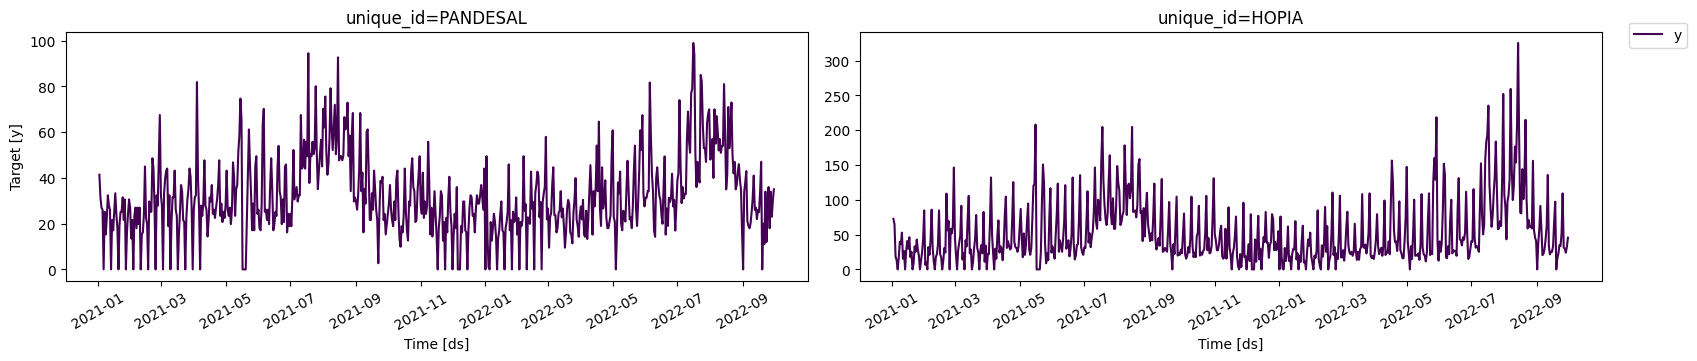

In [4]:
plot_series(df=df, ids=["PANDESAL", "HOPIA"], palette="viridis")

## BASELINE MODELS

In [5]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive

In [6]:
#pip install statsforecast

In [7]:
horizon = 7;
models = [
    Naive(),
    HistoricAverage(),
    WindowAverage(window_size = 7),
    SeasonalNaive(season_length = 7)
]
sf = StatsForecast(models, freq='D')
sf.fit(df=df)
preds = sf.predict(h=horizon)

In [8]:
preds

,unique_id,ds,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,2022-09-29,10.0,8.974359,2.857143,0.0
1,12 MACARON,2022-09-30,10.0,8.974359,2.857143,0.0
2,12 MACARON,2022-10-01,10.0,8.974359,2.857143,10.0
3,12 MACARON,2022-10-02,10.0,8.974359,2.857143,0.0
4,12 MACARON,2022-10-03,10.0,8.974359,2.857143,0.0
...,...,...,...,...,...,...
842,VIK BREAD,2022-10-03,32.4,14.566091,12.342857,0.0
843,VIK BREAD,2022-10-04,32.4,14.566091,12.342857,0.0
844,VIK BREAD,2022-10-05,32.4,14.566091,12.342857,0.0
845,VIK BREAD,2022-10-06,32.4,14.566091,12.342857,0.0


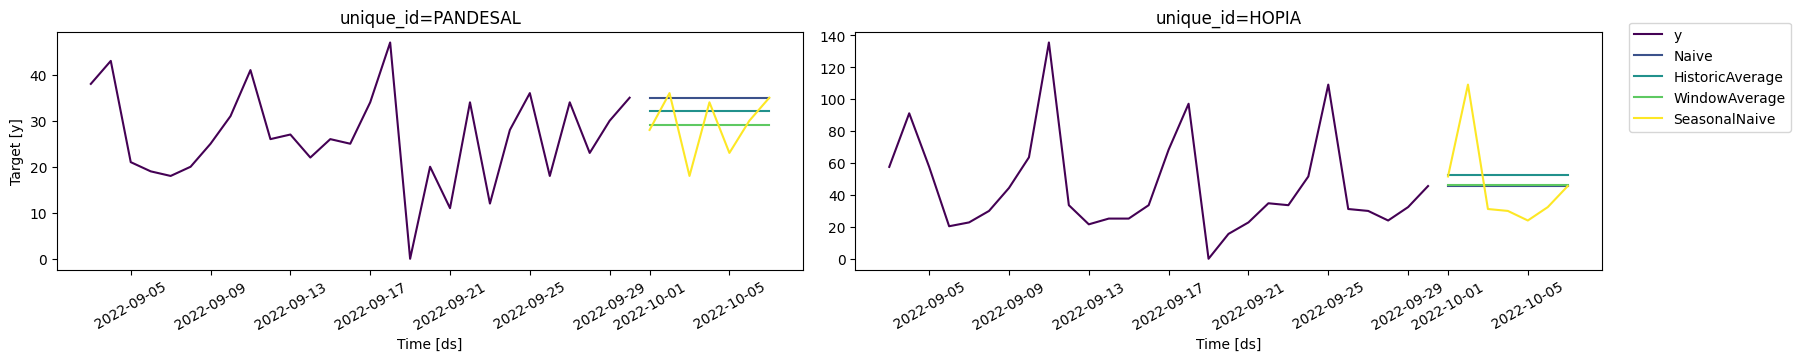

In [9]:
plot_series(
    df=df, 
    forecasts_df=preds, 
    ids=["PANDESAL", "HOPIA"], 
    max_insample_length=28, 
    palette="viridis")

In [10]:
### Evaluate the models

In [11]:
test = df.groupby('unique_id').tail(7)
train = df.drop(test.index).reset_index(drop = True)

sf.fit(df = train)
preds = sf.predict(h=horizon)
eval_df = pd.merge(test, preds, 'left', ['ds', 'unique_id'])

In [12]:
evaluation = evaluate(
    eval_df,
    metrics = [mae]
)
evaluation.head()

,unique_id,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,mae,2.857143,6.961771,3.469388,4.285714
1,BINANGKAL,mae,0.000000,0.537572,0.642857,0.642857
2,BRIOCHE,mae,3.428571,4.493878,4.040816,9.428571
3,BRIOCHETTE,mae,1.000000,1.109041,1.000000,1.000000
4,BROWNIES,mae,0.357143,0.588235,0.357143,0.357143


In [13]:
evaluation = evaluation.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()

In [14]:
evaluation

,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,6.107556,5.228439,5.011663,4.613636


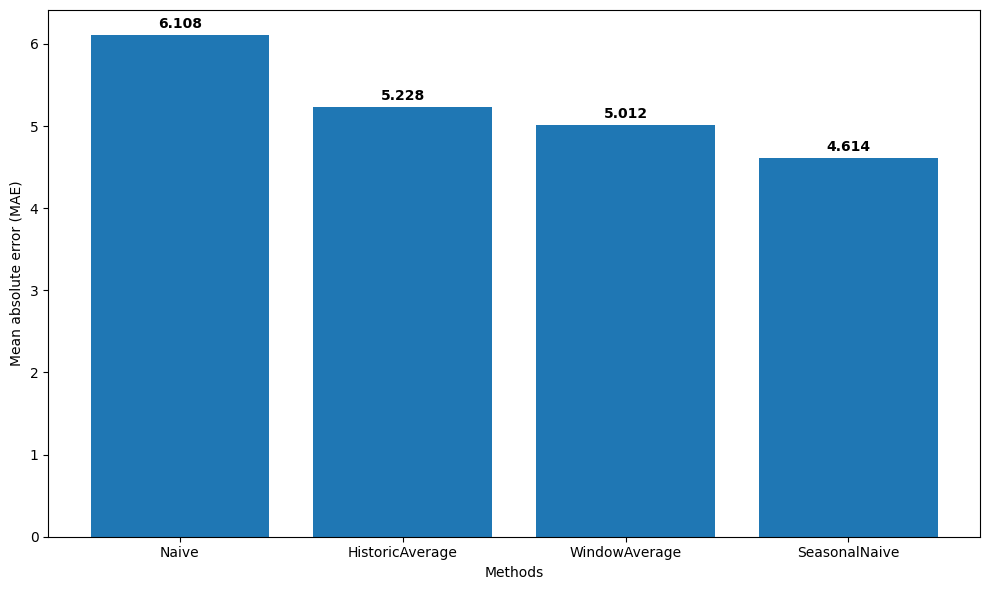

In [15]:
methods = evaluation.columns[1:].tolist()  
values = evaluation.iloc[0, 1:].tolist() 

plt.figure(figsize=(10, 6))
bars = plt.bar(methods, values)

for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()

## ARIMA
### AutoRegressive Integrated Moving Average

In [16]:
from statsforecast.models import AutoARIMA

In [17]:
unique_id = ['PANDESAL', 'HOPIA']
small_train = train[train['unique_id'].isin(unique_id)]
small_test = test[test['unique_id'].isin(unique_id)]

models = [
    AutoARIMA(seasonal = False, alias = "ARIMA"),
    AutoARIMA(season_length=7, alias = "SARIMA")
]

sf = StatsForecast(models = models, freq='D')
sf.fit(df=small_train)
arima_preds = sf.predict(h=horizon)

arima_eval_df = pd.merge(arima_preds, eval_df, 'inner', ['ds', 'unique_id'])
arima_eval = evaluate(
    arima_eval_df,
    metrics=[mae]
)
arima_eval

,unique_id,metric,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,HOPIA,mae,14.565395,10.359143,17.485714,22.618934,18.244898,12.857143
1,PANDESAL,mae,9.353152,7.449083,17.142857,5.455193,7.877551,12.571429


In [18]:
arima_eval = arima_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()

In [19]:
arima_eval

,metric,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,11.959274,8.904113,17.314286,14.037063,13.061224,12.714286


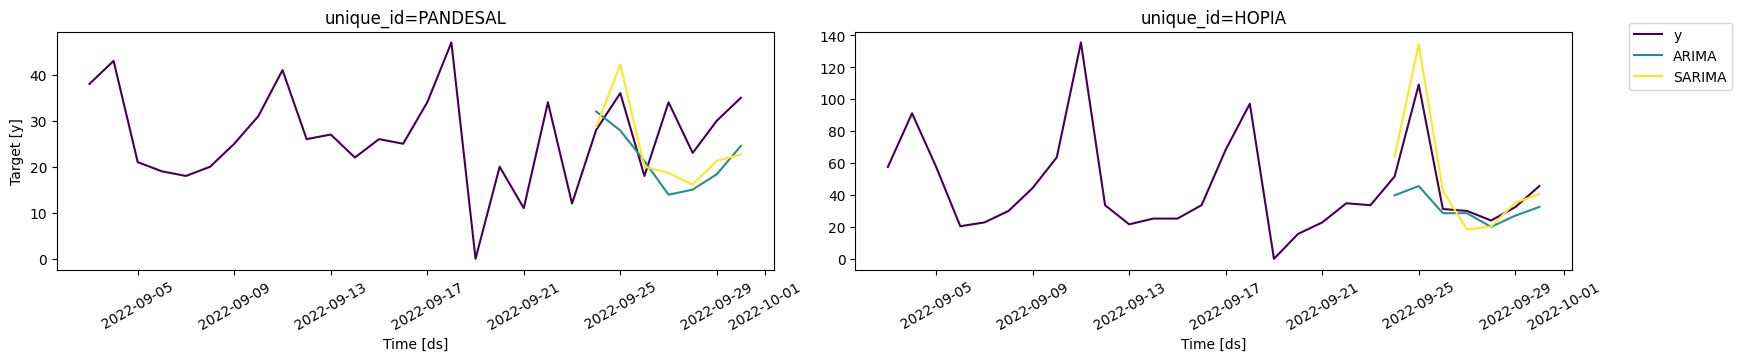

In [20]:
plot_series(
    df=df, 
    forecasts_df=arima_preds, 
    ids=["PANDESAL", "HOPIA"], 
    max_insample_length=28, 
    palette="viridis")

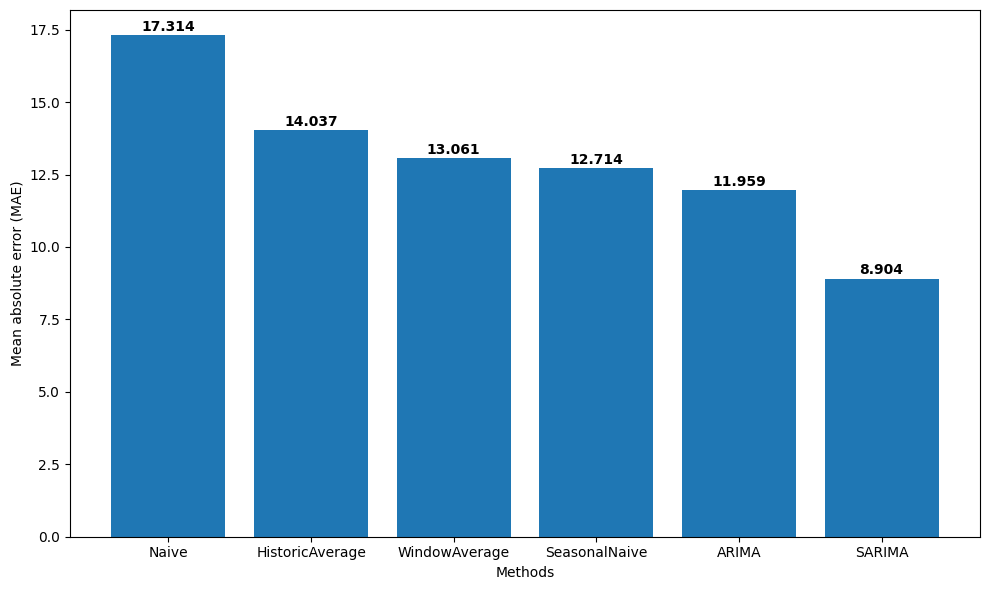

In [21]:
methods = arima_eval.columns[1:].tolist()  
values = arima_eval.iloc[0, 1:].tolist() 

sorted_data = sorted(zip(methods, values), key=lambda x: x[1], reverse=True)
methods_sorted, values_sorted = zip(*sorted_data)

plt.figure(figsize=(10, 6))
bars = plt.bar(methods_sorted, values_sorted)

for bar, value in zip(bars, values_sorted):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()

## CROSS VALIDATION

In [22]:
small_df = df[df['unique_id'].isin(unique_id)]

models = [
    SeasonalNaive(season_length=7),
    AutoARIMA(seasonal=False, alias="ARIMA"),
    AutoARIMA(season_length=7, alias="SARIMA")
]

sf = StatsForecast(models=models, freq="D")

cv_df = sf.cross_validation(
    h=horizon,
    df=small_df,
    n_windows=8,
    step_size=horizon,
    refit=True
)

cv_df.head()

,unique_id,ds,cutoff,y,SeasonalNaive,ARIMA,SARIMA
0,HOPIA,2022-08-06,2022-08-05,129.6,133.2,121.335395,132.754462
1,HOPIA,2022-08-07,2022-08-05,259.2,252.0,160.264173,189.041302
2,HOPIA,2022-08-08,2022-08-05,145.2,108.0,113.869776,103.375676
3,HOPIA,2022-08-09,2022-08-05,99.6,90.0,117.955440,72.144850
4,HOPIA,2022-08-10,2022-08-05,120.0,43.2,82.508666,65.775295


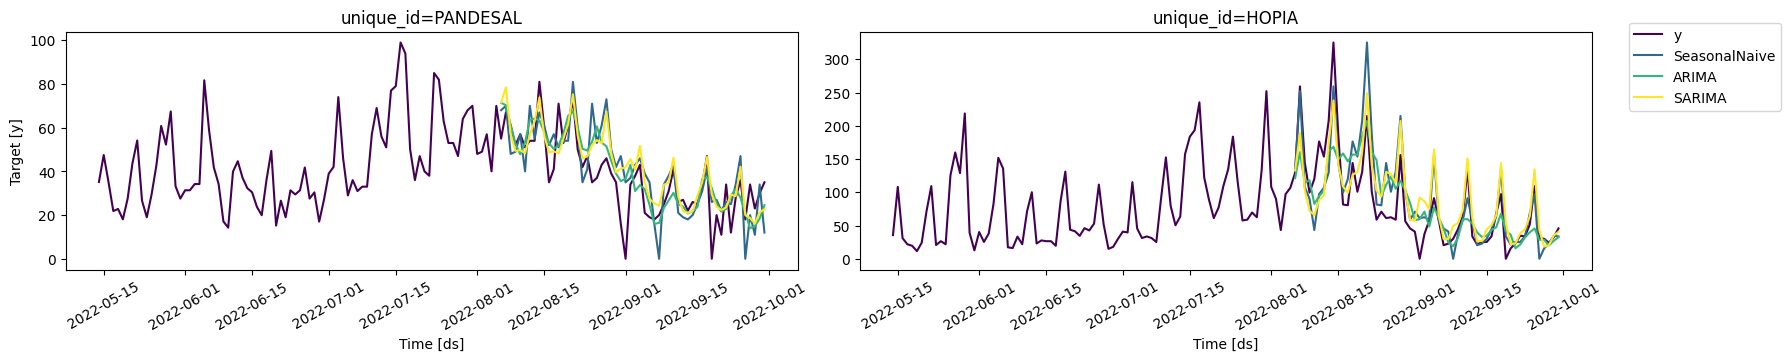

In [23]:
plot_series(
    df=small_df, 
    forecasts_df=cv_df.drop(["y", "cutoff"], axis=1), 
    ids=["PANDESAL", "HOPIA"], 
    max_insample_length=140, 
    palette="viridis")

In [24]:
cv_eval = evaluate(
    cv_df.drop(['cutoff'], axis=1),
    metrics = [mae]
)

cv_eval = cv_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()

In [25]:
cv_eval

,metric,SeasonalNaive,ARIMA,SARIMA
0,mae,21.117857,21.17093,19.281295


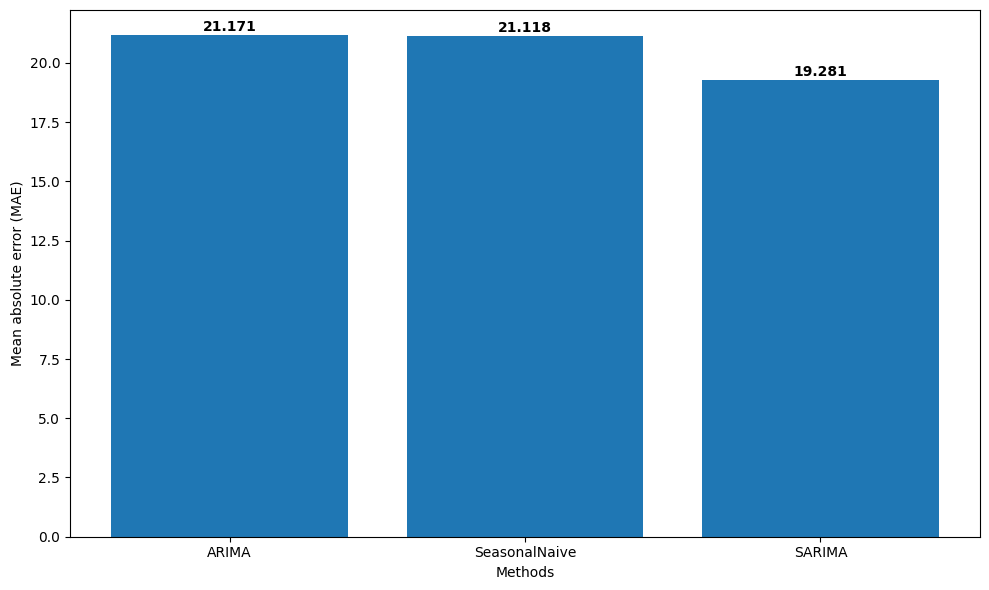

In [26]:
methods = cv_eval.columns[1:].tolist()  
values = cv_eval.iloc[0, 1:].tolist() 

sorted_data = sorted(zip(methods, values), key=lambda x: x[1], reverse=True)
methods_sorted, values_sorted = zip(*sorted_data)

plt.figure(figsize=(10, 6))
bars = plt.bar(methods_sorted, values_sorted)

for bar, value in zip(bars, values_sorted):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()